In [1]:
import pandas as pd

df = pd.read_csv("data/emails.csv")

In [2]:
VECTOR_DB_NAME = "emails_e5_qdrant"

In [3]:
from collections import defaultdict
from langchain_experimental.text_splitter import SemanticChunker
from langchain_core.documents import Document
import numpy as np
import re
from typing import List, Dict, Any, Optional
from gliner import GLiNER

class EnhancedSemanticChunker(SemanticChunker):
    """Enhanced Semantic Chunker with sentence-level overlap and NER-aware chunking.

    This chunker extends the SemanticChunker with:
    1. Controllable sentence overlap between chunks
    2. NER-aware chunk boundaries using GLiNER
    """

    def __init__(
        self,
        embeddings: Any,
        gliner_model: GLiNER,
        breakpoint_threshold_type: str = "percentile",
        breakpoint_threshold_amount: int = 95,
        min_chunk_size: int = 5,
        max_chunk_size: Optional[int] = None,
        overlap_sentences: int = 1,
    ):
        """Initialize the enhanced semantic chunker.

        Args:
            embeddings: The embeddings to use for semantic similarity.
            gliner_model: A loaded GLiNER model instance.
            breakpoint_threshold_type: How to determine breakpoints ('percentile' or 'standard_deviation').
            breakpoint_threshold_amount: The threshold amount for breakpoints.
            min_chunk_size: Minimum chunk size in sentences.
            max_chunk_size: Maximum chunk size in sentences (not used in parent class).
            overlap_sentences: Number of sentences to include before and after the main chunk.
        """
        super().__init__(
            embeddings=embeddings,
            breakpoint_threshold_type=breakpoint_threshold_type,
            breakpoint_threshold_amount=breakpoint_threshold_amount,
            min_chunk_size=min_chunk_size,
        )
        self.max_chunk_size = max_chunk_size
        self.overlap_sentences = overlap_sentences
        self.gliner_model = gliner_model
        self.ner_labels = ["date", "location", "person", "action", "finance", "legal", "event", "product", "organization"]

    def _split_sentences(self, text: str) -> List[str]:
        # Basic sentence splitter using regex; can replace with spaCy or nltk if needed
        return [s.strip() for s in re.split(r'(?<=[.!?]) +', text) if s.strip()]

    def _get_ner_spans(self, text: str) -> List[Dict[str, int]]:
        try:
            if len(text.split()) <= 300:
                entities = self.gliner_model.predict_entities(text, self.ner_labels, threshold=0.5)
                return [(e['start'], e['end']) for e in entities if 'start' in e and 'end' in e], entities
            else:
                return self._get_ner_spans_long(text)
        except Exception as e:
            print(f"NER extraction error: {e}")
            return []
        
    def _get_ner_spans_long(self, text: str) -> List[Dict[str, int]]:
        try:
            max_tokens = 300
            sentences = self._split_sentences(text)
            chunks = []
            current_chunk = []
            current_length = 0

            for sentence in sentences:
                tokens = sentence.split()
                if current_length + len(tokens) > max_tokens:
                    chunks.append(" ".join(current_chunk))
                    current_chunk = tokens
                    current_length = len(tokens)
                else:
                    current_chunk.extend(tokens)
                    current_length += len(tokens)
            if current_chunk:
                chunks.append(" ".join(current_chunk))

            all_entities = []
            all_spans = []
            for chunk in chunks:
                try:
                    entities = self.gliner_model.predict_entities(chunk, self.ner_labels, threshold=0.5)
                    spans = [(e['start'], e['end']) for e in entities if 'start' in e and 'end' in e]
                    all_spans.extend(spans)
                    all_entities.extend(entities)
                except Exception as e:
                    print(f"NER extraction error in chunk: {e}")

            return all_spans, all_entities

        except Exception as e:
            print(f"NER extraction error: {e}")
            return []

        
    def _format_gliner_entities(self, entities: list) -> str:
        if not entities:
            return ""
        
        grouped = defaultdict(list)
        for ent in entities:
            label = ent["label"].lower()
            text = ent["text"].strip()
            if text not in grouped[label]:
                grouped[label].append(text)

        phrases = []
        for label, items in grouped.items():
            readable_items = ", ".join(items)
            if label == "person":
                phrases.append(f"people mentioned include {readable_items}")
            elif label == "date":
                phrases.append(f"dates mentioned include {readable_items}")
            elif label == "location":
                phrases.append(f"locations mentioned include {readable_items}")
            elif label == "finance":
                phrases.append(f"financial terms include {readable_items}")
            elif label == "organization":
                phrases.append(f"organizations mentioned include {readable_items}")
            elif label == "product":
                phrases.append(f"products or services mentioned include {readable_items}")
            elif label == "event":
                phrases.append(f"events mentioned include {readable_items}")
            elif label == "legal":
                phrases.append(f"legal terms mentioned include {readable_items}")
            elif label == "action":
                phrases.append(f"actions or verbs include {readable_items}")
            else:
                phrases.append(f"{label}s mentioned include {readable_items}")

        return "This passage contains " + "; ".join(phrases) + ". "


    def _adjust_chunk_boundaries(self, text: str, chunks: List[str], spans: List[tuple]) -> List[str]:
        adjusted_chunks = []
        for chunk in chunks:
            start_idx = text.find(chunk)
            end_idx = start_idx + len(chunk)

            # Extend chunk to include overlapping entity spans
            for ent_start, ent_end in spans:
                if start_idx < ent_end and end_idx > ent_start:
                    start_idx = min(start_idx, ent_start)
                    end_idx = max(end_idx, ent_end)

            adjusted_chunk = text[start_idx:end_idx].strip()
            adjusted_chunks.append(adjusted_chunk)

        return adjusted_chunks

    def create_documents(
        self,
        texts: List[str],
        metadatas: Optional[List[Dict[str, Any]]] = None
    ) -> List[Document]:
        if metadatas is None:
            metadatas = [{} for _ in texts]

        all_docs = []

        for i, (text, metadata) in enumerate(zip(texts, metadatas)):
            sentences = self._split_sentences(text)
            sentence_to_idx = {s: idx for idx, s in enumerate(sentences)}
            spans, entities = self._get_ner_spans(text)
            raw_chunks = self.split_text(text)
            adjusted_chunks = self._adjust_chunk_boundaries(text, raw_chunks, spans)

            for chunk in adjusted_chunks:
                chunk_sentences = self._split_sentences(chunk)

                if not chunk_sentences:
                    continue

                first_sentence = chunk_sentences[0]
                last_sentence = chunk_sentences[-1]

                start_idx = sentence_to_idx.get(first_sentence, 0)
                end_idx = sentence_to_idx.get(last_sentence, start_idx)

                prefix = sentences[max(0, start_idx - self.overlap_sentences):start_idx]
                suffix = sentences[end_idx + 1:end_idx + 1 + self.overlap_sentences]

                full_chunk = " ".join(prefix + chunk_sentences + suffix).strip()
                
                metadata["entities"] = self._format_gliner_entities(entities)
                all_docs.append(Document(
                    page_content="passage: " + full_chunk,
                    metadata=metadata
                ))

        return all_docs

    def split_documents(self, documents: List[Document]) -> List[Document]:
        texts = [doc.page_content for doc in documents]
        metadatas = [doc.metadata for doc in documents]
        return self.create_documents(texts, metadatas)


In [4]:
email_texts = df["message"].iloc[:500].dropna().tolist()

In [5]:
import re

def clean_text(text: str) -> str:
    """
    Clean text while preserving useful characters:
    - Removes weird/unprintable symbols
    - Keeps letters, numbers, basic punctuation: @ . , ? : ; ! _ ( ) &
    - Normalizes whitespace
    """
    # Remove anything not in the allowed set
    text = re.sub(r"[^A-Za-z0-9@.,?;:!()&\_ ]", '', text)
    
    # Normalize whitespace
    text = re.sub(r"\s+", " ", text)
    
    return text.strip()


In [6]:
import faiss
import numpy as np
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_experimental.text_splitter import SemanticChunker


# Use Microsoft E5 model instead of MPNet
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True}  # Uses the cosine similarity
modelemb = HuggingFaceEmbeddings(
    model_name="intfloat/e5-base-v2", #sentence-transformers/all-mpnet-base-v2
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)

C:\Users\ncvn\AppData\Local\Temp\ipykernel_24284\4264580791.py:11: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  modelemb = HuggingFaceEmbeddings(
c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
import torch
from gliner import GLiNER
from langchain_experimental.text_splitter import SemanticChunker
import spacy
import re

# ============ Setup Models ============

# Load GLiNER for NER
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gliner_model = GLiNER.from_pretrained("urchade/gliner_medium-v2.1")
gliner_model.to(DEVICE)

# Load spaCy (if fallback needed)
nlp = spacy.load("en_core_web_sm")

# ============ Configuration ============
labels = ["date", "location", "person", "action", "finance", "legal", "event", "product", "organization"]

# ============ Helper Functions ============
from dateutil import parser

def parse_email_date(date_tokens: List[str]) -> str:
    raw_date_str = " ".join(date_tokens)
    try:
        parsed = parser.parse(raw_date_str, fuzzy=True)
        return parsed.strftime("%m-%d-%Y")
    except Exception as e:
        print(f"Date parse error: {e}")
        return "unknown"


def extract_email_metadata(msg):
    split_msg = msg.split()
    metadata = {}
    try:
        metadata['sender'] = split_msg[split_msg.index("From:") + 1]
        recips = []
        try:
            for idx in range(split_msg.index("To:") + 1, split_msg.index("Subject:")):
                recips.append(split_msg[idx])
        except:
            for idx in range(split_msg.index("X-To:") + 1, split_msg.index("Subject:")):
                recips.append(split_msg[idx])
        metadata['recipient'] = " ".join(recips)
        metadata['date'] = parse_email_date(split_msg[split_msg.index("Date:") + 1: split_msg.index("Date:") + 7])
        metadata['subject'] = " ".join(split_msg[split_msg.index("Subject:") + 1:split_msg.index("Mime-Version:")])
    except Exception as e:
        print("Metadata extraction error:", e)
    return metadata, split_msg

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\transformers\convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [8]:
from pprint import pprint
import random
msg = df['message'][random.randint(0,500)]
print(msg)
print(clean_text(msg))

# Example usage of our new EnhancedSemanticChunker
enhanced_chunker = EnhancedSemanticChunker(
    embeddings=modelemb,
    breakpoint_threshold_type="percentile",
    breakpoint_threshold_amount=50,  
    min_chunk_size=5,
    overlap_sentences=1,  
    gliner_model=gliner_model
)


# Test the enhanced chunker on a sample email
sample_email = msg
metadata, split_msg = extract_email_metadata(sample_email)
msg_start = split_msg.index("X-FileName:")
full_content = clean_text(" ".join(split_msg[msg_start + 3:]))
# print(full_content)
# Create document with the enhanced chunker
documents = enhanced_chunker.create_documents(
    texts=[full_content],
    metadatas=[metadata]
)

print(f"Created {len(documents)} enhanced chunks")
for i, doc in enumerate(documents):  
    print(f"\n--- Chunk {i+1}/{len(documents)} ---")
    print(f"Content: {doc.page_content}")
    print(f"Metadata: {doc.metadata}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Message-ID: <30625995.1075855726460.JavaMail.evans@thyme>
Date: Mon, 5 Mar 2001 01:38:00 -0800 (PST)
From: phillip.allen@enron.com
To: don.black@enron.com
Subject: Re: Producer Services
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Don Black
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_June2001\Notes Folders\'sent mail
X-Origin: Allen-P
X-FileName: pallen.nsf

Don,

I was out last week.  Regarding the Montana supply, you can refer them to 
Mark Whitt in Denver.  

Let me know when you want to have the other meeting.

Also, we frequently give out quotes to mid-marketers on Fred LaGrasta's desk 
or Enron marketers in New York where the customer is EES.  I don't understand 
why your people don't contact the desk directly.

Phillip
MessageID: 30625995.1075855726460.JavaMail.evans@thymeDate: Mon, 5 Mar 2001 01:38:00 0800 (PST)From: phillip.allen@enron.comTo: don.black@enron.comSubject: Re: Producer ServicesMimeVersion: 

In [9]:
len(email_texts)

500

In [10]:
from langchain_core.documents import Document
import pprint


def create_docslist():
    docslist = []
    for i, sample_email in enumerate(email_texts):
        print(f"Processing email {i+1}/{len(email_texts)}")
        metadata, split_msg = extract_email_metadata(sample_email)
        msg_start = split_msg.index("X-FileName:")
        full_content = clean_text(" ".join(split_msg[msg_start + 3:]))
        # print(full_content)
        # Create document with the enhanced chunker
        documents = enhanced_chunker.create_documents(
            texts=[full_content],
            metadatas=[metadata]
        )

        print(f"Created {len(documents)} enhanced chunks")
        for i, doc in enumerate(documents):  
            print(f"\n--- Chunk {i+1}/{len(documents)} ---")
            print(f"Content: {doc.page_content}")
            print(f"Metadata: {doc.metadata}")
        docslist.extend(documents)
    return docslist

In [ ]:
import numpy as np

def l2_normalize(embeddings: np.ndarray) -> np.ndarray:
    """
    L2-normalizes an array.
    If the input is 1D, normalize the whole vector.
    If it's 2D, normalize each row.
    """
    if embeddings.ndim == 1:
        norm = np.linalg.norm(embeddings)
        return embeddings / norm if norm != 0 else embeddings
    else:
        norm = np.linalg.norm(embeddings, axis=1, keepdims=True)
        norm[norm == 0] = 1  # avoid division by zero
        return embeddings / norm

# docslist = create_docslist()

# # Extract text from Document objects
# docs_texts = [doc.page_content for doc in docslist]  # Get only text content

# # Generate embeddings for each text
# embeddings = modelemb.embed_documents(docs_texts)  # List[List[float]]

# embeddings = l2_normalize(np.array(embeddings))  # Ensure it's NumPy and normalized



Processing email 1/500
Created 1 enhanced chunks

--- Chunk 1/1 ---
Content: passage: Here is our forecast
Metadata: {'sender': 'phillip.allen@enron.com', 'recipient': 'tim.belden@enron.com', 'date': '05-14-2001', 'subject': '', 'entities': ''}
Processing email 2/500
Created 5 enhanced chunks

--- Chunk 1/5 ---
Content: passage: Traveling to have a business meeting takes the fun out of the trip. Especially if you have to prepare a presentation. I would suggest holding the business plan meetings here then take a trip without any formal business meetings. I would even try and get some honest opinions on whether a trip is even desired or necessary. As far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not. Too often the presenter speaks and the others are quiet just waiting for their turn. The meetings might be better if held in a round table discussion format.
Metadata: {'sender'

c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\gliner\data_processing\processor.py:296: UserWarning: Sentence of length 385 has been truncated to 384
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")


Created 6 enhanced chunks

--- Chunk 1/6 ---
Content: passage: Forwarded by Phillip K AllenHOUECT on 09262000 02:00 PM Reschedule Chairperson: Richard Burchfield Sent by: Cindy Cicchetti Start: 10032000 02:30 PM End: 10032000 03:30 PM Description: Gas PhysicalFinancail Positions Room 2537 This meeting repeats starting on (if the date occurs on a weekend the meeting ). Meeting Dates: Fletcher J SturmHOUECT Scott NealHOUECT Hunter S ShivelyHOUECT Phillip K AllenHOUECT Allan SeverudeHOUECT Scott MillsHOUECT Russ SeversonHOUECT Detailed description: Forwarded by Phillip K AllenHOUECT on 09262000 02:00 PM Confirmation Chairperson: Richard Burchfield Sent by: Cindy Cicchetti Start: 10032000 02:30 PM End: 10032000 03:30 PM Description: Gas PhysicalFinancail Positions Room 2537 This meeting repeats starting on (if the date occurs on a weekend the meeting ). Meeting Dates: Fletcher J SturmHOUECT Scott NealHOUECT Hunter S ShivelyHOUECT Phillip K AllenHOUECT Allan SeverudeHOUECT Scott MillsHOUECT

c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\gliner\data_processing\processor.py:296: UserWarning: Sentence of length 624 has been truncated to 384
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")


Created 9 enhanced chunks

--- Chunk 1/9 ---
Content: passage: Forwarded by Phillip K AllenHOUECT on 05012001 0 2:14 PM Outlook Migration Team@ENRON 04272001 01:01 PM To:09Allison HortonNAEnron@ENRON, Amir BaigNAEnron@ENRON, Brandon Bang erterNAEnron@Enron, Brian EllisCorpEnron@Enron, Charles PhilpottHRCor pEnron@ENRON, Chris P WoodNAEnron@Enron, Chris TullHOUECT@ECT, Dale Sm ithCorpEnron@ENRON, Dave JuneNAEnron@ENRON, Donald SuttonNAEnron@Enro n, Felicia BuenrostroHRCorpEnron@ENRON, Johnna MorrisonCorpEnron@ENRON , Joe DornCorpEnron@ENRON, Kathryn SchulteaHRCorpEnron@ENRON, Leon McD owellNAEnron@ENRON, Leticia BarriosCorpEnron@ENRON, Milton BrownHRCor pEnron@ENRON, Raj PerubhatlaCorpEnron@Enron, Shekar KomatireddyNAEnron @Enron, Andrea YowmanCorpEnron@ENRON, Angie OBrianHRCorpEnron@ENRON, Bonne CastellanoHRCorpEnron@ENRON, Gwynn GorsuchNAEnron@ENRON, Jo Ann MatsonCorpEnron@ENRON, LaQuitta WashingtonHRCorpEnron@ENRON, Rick John sonHRCorpEnron@ENRON, Sandra LighthillHRCorpEnron@ENRON, V

c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\gliner\data_processing\processor.py:296: UserWarning: Sentence of length 639 has been truncated to 384
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")


Created 11 enhanced chunks

--- Chunk 1/11 ---
Content: passage: Forwarded by Phillip K AllenHOUECT on 05012001 0 2:14 PM Outlook Migration Team@ENRON 04272001 01:00 PM To:09Allison HortonNAEnron@ENRON, Amir BaigNAEnron@ENRON, Brandon Bang erterNAEnron@Enron, Brian EllisCorpEnron@Enron, Charles PhilpottHRCor pEnron@ENRON, Chris P WoodNAEnron@Enron, Chris TullHOUECT@ECT, Dale Sm ithCorpEnron@ENRON, Dave JuneNAEnron@ENRON, Donald SuttonNAEnron@Enro n, Felicia BuenrostroHRCorpEnron@ENRON, Johnna MorrisonCorpEnron@ENRON , Joe DornCorpEnron@ENRON, Kathryn SchulteaHRCorpEnron@ENRON, Leon McD owellNAEnron@ENRON, Leticia BarriosCorpEnron@ENRON, Milton BrownHRCor pEnron@ENRON, Raj PerubhatlaCorpEnron@Enron, Shekar KomatireddyNAEnron @Enron, Andrea YowmanCorpEnron@ENRON, Angie OBrianHRCorpEnron@ENRON, Bonne CastellanoHRCorpEnron@ENRON, Gwynn GorsuchNAEnron@ENRON, Jo Ann MatsonCorpEnron@ENRON, LaQuitta WashingtonHRCorpEnron@ENRON, Rick John sonHRCorpEnron@ENRON, Sandra LighthillHRCorpEnron@ENRON,

c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\gliner\data_processing\processor.py:296: UserWarning: Sentence of length 613 has been truncated to 384
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")


Created 11 enhanced chunks

--- Chunk 1/11 ---
Content: passage: Outlook Migration Team@ENRON 05112001 01:49 PM To:09Cheryl WilchynskiHRCorpEnron@ENRON, Cindy R WardNAEnron@ENRON, J o Ann HillCorpEnron@ENRON, Sonja GallowayCorpEnron@Enron, Bilal BajwaN AEnron@Enron, Binh PhamHOUECT@ECT, Bradley JonesENRON@enronXgate, Bruce MillsCorpEnron@ENRON, Chance RabonENRON@enronXgate, Chuck AmesNAEnron @Enron, David BaumbachHOUECT@ECT, Jad DoanENRON@enronXgate, ONeal D Win freeHOUECT@ECT, Phillip M LoveHOUECT@ECT, SladanaAnna KulicENRON@enro nXgate, Victor GuggenheimHOUECT@ECT, Alejandra ChavezNAEnron@ENRON, Ann e BikeEnron@EnronXGate, Carole FrankNAEnron@ENRON, Darron C GironHOUEC T@ECT, Elizabeth L HernandezHOUECT@ECT, Elizabeth ShimCorpEnron@ENRON, Jeff RoyedCorpEnron@ENRON, Kam KeiserHOUECT@ECT, Kimat SinglaHOUECT@E CT, Kristen ClauseENRON@enronXgate, Kulvinder FowlerNAEnron@ENRON, Kyle R LillyHOUECT@ECT, Luchas JohnsonNAEnron@Enron, Maria GarzaHOUECT@ECT , Patrick RyderNAEnron@Enron, Ryan OR

c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\gliner\data_processing\processor.py:296: UserWarning: Sentence of length 1014 has been truncated to 384
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")


Created 9 enhanced chunks

--- Chunk 1/9 ---
Content: passage: is GIS info? Can you do this?
Metadata: {'sender': 'phillip.allen@enron.com', 'recipient': 'ina.rangel@enron.com', 'date': '06-30-2000', 'subject': '(Reminder) Update GIS Information', 'entities': 'This passage contains people mentioned include Phillip K AllenHOUECT, Raymond BowenHOUECT, Jeff DonahueHOUECT, John J LavoratoCorpEnron, George McClellanHOUECT, Colleen SullivanHOUECT, Greg HermansCorpEnron, Paul AdairCorpEnron, Jaime AlatorreNAEnron, Brad AlfordECPHOUECT, Tim BeldenHOUECT, Greg BlairCorpEnron, Brad BlesieCorpEnron, Cary M CarrabineCorpEnron, George CarrickHOUECT, Douglas CliffordCorpEnron, Bob CraneHOUECT, Kent DensleyCorpEnron, Ranabir DuttCorpEnron, Craig A FoxHOUECT, David HoweCorpEnron, Scott JoseyCorpEnron, Billy LemmonsCorpEnron, Laura LuceCorpEnron, Richard LydeckerCorpEnron, Jesus MelendrezCorpEnron, Michelle ParksCorpEnron, Steve PruettCorpEnron, Cliff SheddNAEnron, Ted Bland, Kathy Schultea; dates ment

c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\gliner\data_processing\processor.py:296: UserWarning: Sentence of length 527 has been truncated to 384
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")


Created 7 enhanced chunks

--- Chunk 1/7 ---
Content: passage: Forwarded by Phillip K AllenHOUECT on 01182000 06:03 PM enorman@living.com on 01182000 02:44:50 PM To: Phillip K AllenHOUECT@ECT cc: ben@living.com, enorman@living.com, stephanie@living.com Subject: RE: Choosing a style Re. Your living.com inquiry Thank you for your inquiry. Please create an account, so we can assist you more effectively in the future.
Metadata: {'sender': 'phillip.allen@enron.com', 'recipient': 'pallen70@hotmail.com', 'date': '01-18-2000', 'subject': 'RE: Choosing a style', 'entities': 'This passage contains people mentioned include Phillip K AllenHOUECT, Erika; organizations mentioned include living.com, living; products or services mentioned include Area Rugs, Sofas, Chairs, Occasional Tables. '}

--- Chunk 2/7 ---
Content: passage: Your living.com inquiry Thank you for your inquiry. Please create an account, so we can assist you more effectively in the future. Go to: http:www.living.comutillogin.jhtml I

c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\gliner\data_processing\processor.py:296: UserWarning: Sentence of length 390 has been truncated to 384
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")


Created 19 enhanced chunks

--- Chunk 1/19 ---
Content: passage: Forwarded by Phillip K AllenHOUECT on 121199 02:39 PM the shockwave.com team shockwave.com@shockwave.m0.net on 110599 02:49:43 AM Please respond to shockwave.com@shockwave.m0.net To: Phillip K AllenHOUECT@ECT cc: Subject: Stick it in your Shockmachine! First ones free. So are the next thousand.
Metadata: {'sender': 'phillip.allen@enron.com', 'recipient': 'pallen70@hotmail.com', 'date': '12-11-1999', 'subject': 'Stick it in your Shockmachine!', 'entities': 'This passage contains people mentioned include Phillip K AllenHOUECT; organizations mentioned include shockwave.com; products or services mentioned include Shockmachine, Arcade Classics, Missile Command, Super Breakout; dates mentioned include Friday night. '}

--- Chunk 2/19 ---
Content: passage: First ones free. So are the next thousand. You know its true: Video games are addictive.
Metadata: {'sender': 'phillip.allen@enron.com', 'recipient': 'pallen70@hotmail.com', '

c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\gliner\data_processing\processor.py:296: UserWarning: Sentence of length 605 has been truncated to 384
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")


Created 11 enhanced chunks

--- Chunk 1/11 ---
Content: passage: Migration Team@ENRON 05112001 01:49 PM To: Cheryl WilchynskiHRCorpEnron@ENRON, Cindy R WardNAEnron@ENRON, Jo Ann HillCorpEnron@ENRON, Sonja GallowayCorpEnron@Enron, Bilal BajwaNAEnron@Enron, Binh PhamHOUECT@ECT, Bradley JonesENRON@enronXgate, Bruce MillsCorpEnron@ENRON, Chance RabonENRON@enronXgate, Chuck AmesNAEnron@Enron, David BaumbachHOUECT@ECT, Jad DoanENRON@enronXgate, ONeal D WinfreeHOUECT@ECT, Phillip M LoveHOUECT@ECT, SladanaAnna KulicENRON@enronXgate, Victor GuggenheimHOUECT@ECT, Alejandra ChavezNAEnron@ENRON, Anne BikeEnron@EnronXGate, Carole FrankNAEnron@ENRON, Darron C GironHOUECT@ECT, Elizabeth L HernandezHOUECT@ECT, Elizabeth ShimCorpEnron@ENRON, Jeff RoyedCorpEnron@ENRON, Kam KeiserHOUECT@ECT, Kimat SinglaHOUECT@ECT, Kristen ClauseENRON@enronXgate, Kulvinder FowlerNAEnron@ENRON, Kyle R LillyHOUECT@ECT, Luchas JohnsonNAEnron@Enron, Maria GarzaHOUECT@ECT, Patrick RyderNAEnron@Enron, Ryan ORourkeENRON@enronXg

c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\gliner\data_processing\processor.py:296: UserWarning: Sentence of length 610 has been truncated to 384
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")


Created 9 enhanced chunks

--- Chunk 1/9 ---
Content: passage: Forwarded by Phillip K AllenHOUECT on 05012001 02:14 PM Outlook Migration Team@ENRON 04272001 01:01 PM To: Allison HortonNAEnron@ENRON, Amir BaigNAEnron@ENRON, Brandon BangerterNAEnron@Enron, Brian EllisCorpEnron@Enron, Charles PhilpottHRCorpEnron@ENRON, Chris P WoodNAEnron@Enron, Chris TullHOUECT@ECT, Dale SmithCorpEnron@ENRON, Dave JuneNAEnron@ENRON, Donald SuttonNAEnron@Enron, Felicia BuenrostroHRCorpEnron@ENRON, Johnna MorrisonCorpEnron@ENRON, Joe DornCorpEnron@ENRON, Kathryn SchulteaHRCorpEnron@ENRON, Leon McDowellNAEnron@ENRON, Leticia BarriosCorpEnron@ENRON, Milton BrownHRCorpEnron@ENRON, Raj PerubhatlaCorpEnron@Enron, Shekar KomatireddyNAEnron@Enron, Andrea YowmanCorpEnron@ENRON, Angie OBrianHRCorpEnron@ENRON, Bonne CastellanoHRCorpEnron@ENRON, Gwynn GorsuchNAEnron@ENRON, Jo Ann MatsonCorpEnron@ENRON, LaQuitta WashingtonHRCorpEnron@ENRON, Rick JohnsonHRCorpEnron@ENRON, Sandra LighthillHRCorpEnron@ENRON, Valeria A Ho

c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\gliner\data_processing\processor.py:296: UserWarning: Sentence of length 615 has been truncated to 384
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")


In [12]:
# np.save("embeddings.npy",embeddings)
# # Create (text, embedding) pairs for FAISS
# text_embedding_pairs = list(zip(docs_texts, embeddings))  # Convert np.array to list

# from langchain_qdrant import Qdrant

# from qdrant_client import QdrantClient
# from qdrant_client.http.models import Distance, VectorParams



# qdrant = Qdrant.from_documents(
#     docslist,
#     modelemb,
#     path="qdrant_db",
#     collection_name="my_documents",
# )

In [13]:
len(email_texts)

500

In [14]:
# len(docslist)

In [15]:
from langchain_community.vectorstores import FAISS
# from tqdm import tqdm  # Sync version of tqdm, works better with notebooks
# import asyncio

# # Define batch insert function
# async def batch_insert(db, docslist, batch_size=40):
#     tasks = []
    
#     for i in range(0, len(docslist), batch_size):
#         batch_docs = docslist[i : i + batch_size]
#         batch_id = i // batch_size

#         async def insert_batch(batch, batch_id=batch_id):
#             await db.aadd_documents(batch)
#             # print(f"Batch {batch_id} added ({len(batch)} docs).")
        
#         tasks.append(insert_batch(batch_docs))  # Appending coroutine, but no args here!

#     # Run all batch insertions concurrently with tqdm
#     for coro in tqdm(tasks, total=len(tasks)):
#         await coro

# # Execute batch insert asynchronously
# async def run_batch_insert(db, docslist):
#     """Run the batch insert asynchronously and return when complete"""
#     await batch_insert(db, docslist, batch_size=40)

# # Assuming `db` and `enhanced_docslist` are defined earlier, run the batch insert
# await run_batch_insert(db, do)


In [16]:
# db.save_local(VECTOR_DB_NAME + "_enhanced")
# print("Enhanced FAISS index updated and saved")

In [13]:
db = FAISS.load_local("email_faiss_normalized_e5_enhanced",modelemb,allow_dangerous_deserialization=True)

In [14]:
model = modelemb

In [15]:
from initialize_groq import init_groq
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.retrieval import create_retrieval_chain
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate

prompt = ChatPromptTemplate.from_template(
        """
            Answer question based on only the context provided. 
            {context}

            Here is question:
            {input}
        """
)

document_prompt = PromptTemplate.from_template(
    "Source: {sender}\nDate: {date}\n Recipients: {recipient}\nSubject: {subject}\nEntities: {entities}\n\nContent: {page_content}"
)

retriever = db.as_retriever(search_kwargs={'k':20, 'search_type':'mmr','lambda_mult':0.2})

_, llm = init_groq(model_name="llama-3.3-70b-versatile")
import random
from initialize_groq import api_keys
llm.groq_api_key = random.choice(api_keys)
document_chain = create_stuff_documents_chain(llm, prompt=prompt, document_prompt=document_prompt)
retrieval_chain = create_retrieval_chain(retriever, document_chain)

# Retrieve Top-K Similar Documents (Initial Broad Search)
# retriever_topk = db.as_retriever(search_kwargs={'k': 20,'fetch_k' : 100, 'search_type': 'similarity_s core_threshold','score_threshold':0.75})  # Retrieve more docs first
retriever_topk = db.as_retriever(search_type="similarity_score_threshold", search_kwargs={'score_threshold':0.1,'k':20})
# MMR for Diversity (Reduce Redundant Docs)
retriever_mmr = db.as_retriever(search_type="mmr", search_kwargs={'lambda_mult': 0})  

# Create the Hybrid Retrieval Pipeline
retrieval_chain_topk = create_retrieval_chain(retriever_topk, document_chain)  # Initial broad search
retrieval_chain_mmr = create_retrieval_chain(retriever_mmr, document_chain)    # Apply MMR re-ranking

In [20]:
# for i, d in enumerate(docslist):
#     print(f"========{i}========")
#     print(d.page_content)

In [16]:
import pprint
# "What does randy need to send a schedule of?",
#     "What are some of randy's action items?",
#     "What is Philip's proposal focused on, and can you provided details about the proposal?",
#     "Can you provide me more detail about the microturbine power generation deal?"
llm.groq_api_key = random.choice(api_keys)
query = "What are some of randy's action items?"
pprint.pprint(retrieval_chain_topk.invoke({"input":query}))
llm.groq_api_key = random.choice(api_keys)
pprint.pprint(retrieval_chain_mmr.invoke({"input":query}))

{'answer': "Based on the provided context, one of Randy's action items is to "
           'resolve an issue with Phillip, as mentioned in the passage: "get '
           'with Randy to resolve." However, the specific details of the issue '
           'to be resolved are not provided in the given context.',
 'context': [Document(metadata={'sender': 'phillip.allen@enron.com', 'recipient': 'william.kelly@enron.com', 'date': '02-09-2000', 'subject': 'Re: APEA - $228,204 hit', 'entities': 'This passage contains actions or verbs include get. '}, page_content='passage: get with randy to resolve.'),
             Document(metadata={'sender': 'phillip.allen@enron.com', 'recipient': 'stagecoachmama@hotmail.com', 'date': '09-12-2000', 'subject': '', 'entities': 'This passage contains dates mentioned include June, July, August; organizations mentioned include Walmart, Ralphs; people mentioned include Lucy, Papes, Phillip. '}, page_content='passage: Description and unit? Try and pull together the sup

In [17]:
from langchain_community.vectorstores.faiss import FAISS
import numpy as np
test_questions = [
    "What does randy need to send a schedule of?",
    "What are some of randy's action items?",
    "What is Philip's proposal focused on, and can you provided details about the proposal?",
    "Can you provide me more detail about the microturbine power generation deal?",
    "What needs to be faxed?"
]
for text in test_questions:
    # Define query
    query = "query: " + text
    pprint.pprint(retrieval_chain_topk.invoke({"input":query}))
    llm.groq_api_key = random.choice(api_keys)
    

{'answer': 'Randy needs to send a schedule of the salary and level of everyone '
           'in the scheduling group.',
 'context': [Document(metadata={'sender': 'phillip.allen@enron.com', 'recipient': 'william.kelly@enron.com', 'date': '02-09-2000', 'subject': 'Re: APEA - $228,204 hit', 'entities': 'This passage contains actions or verbs include get. '}, page_content='passage: get with randy to resolve.'),
             Document(metadata={'sender': 'phillip.allen@enron.com', 'recipient': 'randall.gay@enron.com', 'date': '10-23-2000', 'subject': '', 'entities': 'This passage contains people mentioned include Patti S, Phillip. '}, page_content='passage: Can you send me a schedule of the salary and level of everyone in the scheduling group. Plus your thoughts on any changes that need to be made. (Patti S for example) Phillip'),
             Document(metadata={'sender': 'phillip.allen@enron.com', 'recipient': 'cbpres@austin.rr.com', 'date': '02-02-2001', 'subject': 'RE: Phillip Allen Respo

In [31]:
from langchain_community.vectorstores.faiss import FAISS
import numpy as np
test_questions = [
    "What does randy need to send a schedule of?",
    "What are some of randy's action items?",
    "What is Philip's proposal focused on, and can you provided details about the proposal?",
    "Can you provide me more detail about the microturbine power generation deal?",
    "What needs to be faxed?"
]
for text in test_questions:
    print("=========================================================")
    query = "query: " + text
    query_embedding = np.array(model.embed_query(query))
    # query_embedding = l2_normalize(query_embedding)  
    topk_results = db.similarity_search_with_score_by_vector(
        embedding=query_embedding.tolist(),  # List[float]
        k=20
    )

    mmr_results = db.max_marginal_relevance_search_with_score_by_vector(
        embedding=query_embedding.tolist(),  # List[float]
        k=20,
        lambda_mult=0.8         
    )

    # Sort by L2 distance (ascending: lower = more similar)
    topk_sorted = sorted(topk_results, key=lambda x: x[1])
    
    mmr_sorted = sorted(mmr_results, key=lambda x: x[1], reverse=True)

    # Display results with L2 distance and cosine similarity
    for doc, mmr_score in mmr_sorted:
        # docembedding = l2_normalize(np.array(modelemb.embed_documents([doc.page_content])))
        # cos_sim = float(np.dot(query_embedding, docembedding.reshape(-1)))
        print(f"Document: {doc.page_content[:100]} | MMR Score: {mmr_score:.4f}")
        
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    for doc, l2_score in topk_sorted:
        # Convert L2 distance to cosine similarity (assuming L2-normalized)
        cosine_sim = 1 - (l2_score ** 2) / 2
        print(f"Document: {doc.page_content[:100]} | L2 Distance: {l2_score:.4f} | Cosine Sim: {cosine_sim:.4f}")


Document: passage: get with randy to resolve. | MMR Score: 0.8123
Document: passage: get with randy to resolve. | MMR Score: 0.8123
Document: passage: Can you send me a schedule of the salary and level of everyone in the scheduling group. Plu | MMR Score: 0.7961
Document: passage: Can you send me a schedule of the salary and level of everyone in the scheduling group. Plu | MMR Score: 0.7961
Document: passage: your email. I will let Jacques know. I guess we can work out the finer points next week. | MMR Score: 0.7908
Document: passage: your email. I will let Jacques know. I guess we can work out the finer points next week. | MMR Score: 0.7908
Document: passage: What we need to focus on is the first bullet in Allans list; the need for a single set of r | MMR Score: 0.7850
Document: passage: What we need to focus on is the first bullet in Allans list; the need for a single set of r | MMR Score: 0.7850
Document: passage: What we need to focus on is the first bullet in Allans list; the need

In [24]:
# for doc in docslist:
#     print(len(doc.page_content.split()))

In [25]:
from langchain_core.tools import tool

# Ensure retrieval_chain is correctly defined before calling this tool
@tool
def ragtool(query: str, num_docs: int) -> str:
    """
    This is a retrieval-augmented generation (RAG) tool that queries a vector store 
    containing Enron emails.
    
    Parameters:
    query (str): The input query for retrieval.
    num_docs (int): The number of documents to retrieve.
    Returns:
    str: The retrieved answer from the vector store.
    """
    try:
        answer = retrieval_chain_topk.invoke({"input": query})['answer']
        return f"Here is the ANSWER. \n ```{answer}```\n DO NOT USE THE TOOL REPEATEDLY. SHOW THE ANSWER TO THE USER. \n"
    except Exception as e:
        return f"Error: Failed to retrieve answer. Details: {str(e)}"

In [44]:
from langchain.tools import tool
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.schema import AttributeInfo

metadata_field_info = [
    AttributeInfo(
        name="date",
        description="Date the email was sent, in the format MM-DD-YYYY",
        type="string",
    ),
    AttributeInfo(
        name="sender",
        description="Email address of the sender",
        type="string",
    ),
    AttributeInfo(
        name="recipient",
        description="Email address of the recipient",
        type="string",
    ),
    AttributeInfo(
        name="subject",
        description="Subject of the email",
        type="string",
    ),
]


@tool
def dynamic_retrieve(query: str, k: int = 5, threshold: float = 0.7) -> list:
    """
    Retrieves relevant documents with customizable parameters using SelfQueryRetriever.
    
    Args:
        query (str): The user question or query.
        k (int): Number of documents to retrieve.
        threshold (float): Minimum similarity threshold.

    Returns:
        list: Retrieved documents.
    """
    retriever = SelfQueryRetriever.from_llm(
        llm=llm,
        vectorstore=db,
        document_contents="Email body content and extracted entities",
        metadata_field_info=metadata_field_info,
        search_kwargs={
            "k": k,
            "fetch_k": 2 * k,
            "score_threshold": threshold,
            "search_type": "similarity_score_threshold"
        }
    )

    docs = retriever.invoke(query)
    retstr = []
    for doc in docs:
        retstr.append(
            f"Source: {doc.metadata.get('sender', '')}\n"
            f"Date: {doc.metadata.get('date', '')}\n"
            f"Recipients: {doc.metadata.get('recipient', '')}\n"
            f"Subject: {doc.metadata.get('subject', '')}\n"
            f"Entities: {doc.metadata.get('entities', '')}\n\n"
            f"Content: {doc.page_content}\n\n"
        )
    return retstr



In [45]:
from typing import Literal
from langchain_core.runnables.history import RunnableWithMessageHistory
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain.memory import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.chat_history import InMemoryChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langgraph.prebuilt import ToolNode, tools_condition



toolnode = ToolNode([dynamic_retrieve])

def call_model(state: MessagesState):
    state["messages"]
    messages = state["messages"]
    #print(messages)
    llm.groq_api_key = random.choice(api_keys)
    llm_with_tool = llm.bind_tools([dynamic_retrieve])
    response = llm_with_tool.invoke(messages)
    
    
    return {"messages": [response]}

from langgraph.graph import END
def router_function(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

memory = MemorySaver()
workflow = StateGraph(MessagesState)    
workflow.add_node("agent", call_model)
workflow.add_node(toolnode)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    router_function,
    {
       "tools": "tools",
       END: END,
    },
)
workflow.add_edge("tools", "agent")
app = workflow.compile(checkpointer=memory)



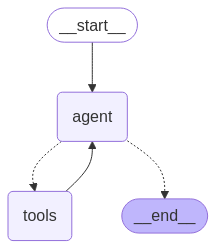

In [46]:
from IPython.display import display_png
display_png(app.get_graph().draw_mermaid_png(),raw=True)

In [47]:
import time
while True:
    theinput = input("Enter something: ")
    if 'exit' in theinput:
        break
    inp = {"messages":[theinput]}
    
    config = {"configurable": {"thread_id": 1}}
    events = app.stream(inp, config=config, stream_mode="values")

    for event in events:
        event["messages"][-1].pretty_print()
    time.sleep(1)

================================ Human Message =================================

what is san juan index distortion
================================== Ai Message ==================================
Tool Calls:
  dynamic_retrieve (call_qt01)
 Call ID: call_qt01
  Args:
    query: San Juan index distortion
    k: 5
    threshold: 0.7
================================= Tool Message =================================
Name: dynamic_retrieve

Error: TypeError("QdrantTranslator.__init__() missing 1 required positional argument: 'metadata_key'")
 Please fix your mistakes.
================================== Ai Message ==================================
Tool Calls:
  dynamic_retrieve (call_frdq)
 Call ID: call_frdq
  Args:
    query: San Juan index distortion
    k: 5
    threshold: 0.7
================================= Tool Message =================================
Name: dynamic_retrieve

Error: TypeError("QdrantTranslator.__init__() missing 1 required positional argument: 'metadata_key'")
 Please

In [48]:
# from typing import Literal, List
# from langchain_core.runnables.history import RunnableWithMessageHistory
# from langgraph.graph import StateGraph, START, END, MessagesState
# from langgraph.checkpoint.memory import MemorySaver
# from langchain.memory import ChatMessageHistory
# from langchain_core.chat_history import BaseChatMessageHistory, InMemoryChatMessageHistory
# from langgraph.prebuilt import ToolNode
# from langchain_core.documents import Document
# from langchain_core.tools import tool
# from langchain.chat_models import ChatOpenAI
# from langchain_core.prompts import ChatPromptTemplate

# # === Define Custom Tools ===


# @tool
# def filter_emails_by_keyword(emails: List[Document], keywords: List[str]) -> List[Document]:
#     """Filter emails that contain the given keywords in the content or metadata."""
#     def filter_email(email):
#         content = email.page_content.lower()
#         metadata = " ".join(str(val).lower() for val in email.metadata.values())
#         return any(keyword.lower() in content or keyword.lower() in metadata for keyword in keywords)
    
#     with concurrent.futures.ThreadPoolExecutor() as executor:
#         filtered_emails = list(filter(None, executor.map(lambda e: e if filter_email(e) else None, emails)))

#     return filtered_emails

# @tool
# def filter_emails_by_metadata(
#     emails: List[Document], sender: str = None, recipient: str = None, date: str = None
# ) -> List[Document]:
#     """Filter emails by metadata fields like sender, recipient, or date."""
#     def filter_email(email):
#         if sender and email.metadata.get("sender", "").lower() != sender.lower():
#             return None
#         if recipient and recipient.lower() not in email.metadata.get("recipient", "").lower():
#             return None
#         if date and date not in email.metadata.get("date", ""):
#             return None
#         return email
    
#     with concurrent.futures.ThreadPoolExecutor() as executor:
#         filtered_emails = list(filter(None, executor.map(filter_email, emails)))
    
#     return filtered_emails

# @tool
# def summarize_emails(emails: List[Document]) -> List[Document]:
#     """Summarize emails before adding them to FAISS."""
#     _,llm = init_groq(model_name="llama-3.3-70b-versatile")
#     prompt = ChatPromptTemplate.from_template("Summarize the following email:\n{email}")
#     summarized_docs = []
#     for email in emails:
#         chain = prompt | llm
#         summary = chain.invoke(email.page_content)
#         summarized_docs.append(Document(page_content=summary.content, metadata=email.metadata))
#     return summarized_docs

# toolnode = ToolNode([ragtool, filter_emails_by_keyword, filter_emails_by_metadata, summarize_emails])
# llm_with_tool = llm.bind_tools([ragtool, filter_emails_by_keyword, filter_emails_by_metadata, summarize_emails])

# # === Define Model Function ===
# def call_model(state: MessagesState):
#     """Modify agent behavior to apply filtering and summarization before RAG."""
#     messages = state["messages"]
#     query = messages[-1]

#     # Step 1: Apply Keyword Filtering
#     filtered_emails = filter_emails_by_keyword.invoke({"emails": docslist, "keywords": [query.content]})

#     # Step 2: Apply Metadata Filtering
#     filtered_emails = filter_emails_by_metadata.invoke(
#         {"emails": filtered_emails, "sender": "", "recipient": "", "date": ""}
#     )

#     # Step 3: Summarize Emails if Needed
#     summarized_emails = summarize_emails.invoke({"emails": filtered_emails})

#     # Step 4: Run RAG Tool on Filtered Emails
#     state["messages"].append("\n")
#     response = llm_with_tool.invoke([summarized_emails])

#     return {"messages": [response]}

# # === Define Router Function ===
# def router_function(state: MessagesState) -> Literal["tools", END]:
#     messages = state["messages"]
#     last_message = messages[-1]
#     if last_message.tool_calls:
#         return "tools"
#     return END

# # === Build LangGraph Workflow ===
# memory = MemorySaver()
# workflow = StateGraph(MessagesState)
# workflow.add_node("agent", call_model)
# workflow.add_node(toolnode)
# workflow.add_edge(START, "agent")
# workflow.add_conditional_edges(
#     "agent",
#     router_function,
#     {
#         "tools": "tools",
#         END: END,
#     },
# )
# workflow.add_edge("tools", "agent")
# app = workflow.compile(checkpointer=memory)

# while True:
#     theinput = input("Enter something: ")
#     if 'exit' in theinput:
#         break
#     inp = {"messages":[theinput]}

#     config = {"configurable": {"thread_id": 1}}
#     events = app.stream(inp, config=config, stream_mode="values")

#     for event in events:
#         event["messages"][-1].pretty_print()

